# ANN Backpropagation algorithm


Formulas based on: https://www.deeplearning.ai/deep-learning-specialization/ Neural Networks and Deep Learning

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import make_classification

## Data Generation

Binary classification problem (yellow dot or purple dot?) for three input variables $x_1$, $x_2$, $x_3$

In [6]:
m = 300
data = make_classification(n_samples=m, n_features=3, n_informative=3, n_redundant=0, n_classes=2, random_state=0)

In [7]:
X = data[0]
Y = data[1]

In [8]:
X.shape


(300, 3)

In [9]:
Y.shape

(300,)

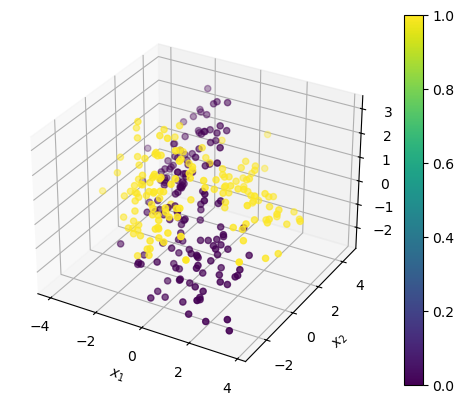

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(X[:,0], X[:,1], X[:,2], c=Y.transpose())
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
fig.colorbar(cax)
plt.show()

# Neural Network

In [12]:
%%html
<iframe src="https://drive.google.com/file/d/1s3mGcho6uv2VdMb4CBsw686qwhpp2mRw/preview" width="640" height="480"></iframe>

$$ 
\begin{bmatrix}
w_{11}^{[1]} & w_{12}^{[1]}  & w_{13}^{[1]}\\
\vdots & \vdots & \vdots \\
\vdots & \vdots & \vdots \\
w_{41}^{[1]} & w_{42}^{[1]}  & w_{43}^{[1]}
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
+
\begin{bmatrix}
b_1^{[1]} \\
b_2^{[1]} \\
b_3^{[1]} \\
b_4^{[1]}
\end{bmatrix}
=
\begin{bmatrix}
z_1^{[1]} \\
z_2^{[1]} \\
z_3^{[1]} \\
z_4^{[1]}
\end{bmatrix}
$$

$$ z^{[1]} = W^{[1]}x + b^{[1]} $$

$$ a^{[1]} = \varphi^{[1]}(z^{[1]}) $$

$$ z^{[2]}  = W^{[2]}a^{[1]} + b^{[2]} $$

$$ a^{[2]} = \varphi^{[2]}(z^{[2]}) $$

## Initialization of Weight Values

In [15]:
np.random.seed(0)

In [16]:
def initialize():
    # Weights W are initialized randomly from a normal distribution with a mean of 0 and a standard deviation of 0.1, while the values of b are set to 0.
    W1 = np.random.normal(0, 0.1, size=(4, 3))
    b1 = np.zeros(shape=(4, 1))
    W2 = np.random.normal(0, 0.1, size=(1,4))
    b2 = np.zeros(shape=(1,1))
    return W1, b1, W2, b2

In [17]:
W1, b1, W2, b2 = initialize()

In [18]:
print('W1 = ', W1)
print('b1 = ', b1)
print('W2 = ', W2)
print('b2 = ', b2)

W1 =  [[ 0.17640523  0.04001572  0.0978738 ]
 [ 0.22408932  0.1867558  -0.09772779]
 [ 0.09500884 -0.01513572 -0.01032189]
 [ 0.04105985  0.01440436  0.14542735]]
b1 =  [[0.]
 [0.]
 [0.]
 [0.]]
W2 =  [[0.07610377 0.0121675  0.04438632 0.03336743]]
b2 =  [[0.]]


In [19]:
assert(W1.shape == (4, 3))
assert(b1.shape == (4, 1))
assert(W2.shape == (1, 4))

In [20]:
np.testing.assert_almost_equal(W2, [[0.07610377, 0.0121675, 0.04438632, 0.03336743]])

### Funkcje aktywacji

In [22]:
def sigmoid(Z):
     # Sigmoid activation function for matrix Z
    return  1/(1+np.exp(-Z))

def leaky_relu(Z):
    # Leaky ReLU activation function for matrix Z (leaky_relu(Z) = max(0.01 * Z, Z))
    return np.maximum(0.01*Z,Z)

def leaky_relu_grad(Z):
 # Derivative of the leaky ReLU function for matrix Z
   # https://numpy.org/doc/stable/reference/generated/numpy.where.html
    return np.where(Z<0,0.01,1) 

In [23]:
testZ = np.array([[-3, -2, -1], [0, 1, 2]])
print('Sigmoid:')
print(sigmoid(testZ))
print('Leaky ReLu:')
print(leaky_relu(testZ))
print('Leaky ReLu derivative:')
print(leaky_relu_grad(testZ))

Sigmoid:
[[0.04742587 0.11920292 0.26894142]
 [0.5        0.73105858 0.88079708]]
Leaky ReLu:
[[-0.03 -0.02 -0.01]
 [ 0.    1.    2.  ]]
Leaky ReLu derivative:
[[0.01 0.01 0.01]
 [1.   1.   1.  ]]


In [24]:
np.testing.assert_almost_equal(sigmoid(testZ), [[0.04742587, 0.11920292, 0.26894142], [0.5, 0.73105858, 0.88079708]])
np.testing.assert_almost_equal(leaky_relu(testZ), [[-0.03, -0.02, -0.01], [0, 1, 2]])
np.testing.assert_almost_equal(leaky_relu_grad(testZ), [[0.01, 0.01, 0.01], [1., 1., 1.]])

## Forward Propagation

Vectorization for Multiple Examples

$$ X = \begin{bmatrix}
x_1 ^{(1)} & x_1 ^{(2)} & \dots & x_1 ^{(m)}\\
x_2 ^{(1)} & x_2 ^{(2)} & \dots & x_2 ^{(m)}\\
x_3 ^{(1)} & x_3 ^{(2)} & \dots & x_3 ^{(m)}
\end{bmatrix} $$

$$ Z^{[1]} =  W^{[1]}X + b^{[1]}  $$
$$ A^{[1]} = \varphi^{[1]}(Z^{[1]}) $$
$$ Z^{[2]} = W^{[2]}A^{[1]} + b^{[2]}  $$
$$ A^{[2]} = \varphi^{[2]}(Z^{[2]}) $$
$$ \hat{Y} = A^{[2]} $$

In [26]:
X.shape

(300, 3)

In [27]:
Xt = X.transpose()

In [28]:
Xt.shape

(3, 300)

In [29]:
Y = Y.reshape(1, m)

In [30]:
def forward(X, W1, W2, b1, b2):
    # We determine the network output and the values in the hidden layers.
    Z1 = np.dot(W1, X) + b1
    A1 = leaky_relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    Y_hat = A2
    return Z1, A1, Z2, A2, Y_hat

In [31]:
Z1, A1, Z2, A2, Y_hat = forward(Xt, W1, W2, b1, b2)

In [32]:
assert(Z1.shape == (4, m))
assert(Z2.shape == (1, m))
assert(Y_hat.shape == (1, m))

In [33]:
np.testing.assert_almost_equal(Y_hat[0][:3], [0.50025724, 0.49987587, 0.50083385])

### Cost Function

For binary classification, we use cross-entropy.
$$ -\frac{1}{m} \sum_{i=1}^m \left( y_i \log(\hat{y}_i) + (1 - y_i)\log(1-\hat{y}_i)\right) $$

In [35]:
def J(Y, Y_hat):
    
  # binary cross-entropy
    return -1*np.mean(Y*np.log(Y_hat)+(1-Y)*np.log(1-Y_hat))

In [36]:
assert(round(J(np.array([[1, 0, 1]]), np.array([[0.98, 0.1, 0.5]])), 4) == 0.2729)

## Calculating Derivatives Using the Backpropagation Method

$$ \frac{\partial J}{\partial Z^{[2]}} = A^{[2]} - Y$$
$$ \frac{\partial J}{\partial W^{[2]}} =\frac{1}{m} \frac{dJ}{\partial Z^{[2]}} A^{[1]T} $$
$$ \frac{\partial J}{\partial b^{[2]}} = \frac{1}{m} np.sum(\frac{dJ}{\partial Z^{[2]}}, axis = 1, keepdims=True) $$
$$\frac{dJ}{\partial Z^{[1]}} = W^{[2]T}\frac{dJ}{\partial Z^{[2]}} * \varphi^{[1]{\prime}}(z_1)$$

$$ \frac{\partial J}{\partial W^{[1]}} = \frac{dJ}{\partial Z^{[1]}} X^T $$
$$ \frac{\partial J}{\partial b^{[1]}} = \frac{1}{m} np.sum(\frac{dJ}{\partial Z^{[1]}}, axis = 1, keepdims=True) $$

In [38]:
def calculate_gradients(Y, A2, A1, Z1, W2, W1, b2, b1, X, m):
    dZ2 = A2 - Y
    dW2 = 1/m*np.dot(dZ2,A1.transpose())
    db2 = 1/m*np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = (np.dot(W2.transpose(),dZ2))*leaky_relu_grad(Z1)
    dW1 = np.dot(dZ1,X.transpose())
    db1 = 1/m*np.sum(dZ1,axis=1,keepdims=True)
    return dW2, db2, dW1, db1

In [39]:
dW2, db2, dW1, db1 = calculate_gradients(Y, A2, A1, Z1, W2, W1, b2, b1, Xt, m)

In [40]:
np.testing.assert_almost_equal(dW2, [[-0.02540348, -0.03184805, -0.00094008, -0.01338454]])
np.testing.assert_almost_equal(db2, [[0.00116861]])
np.testing.assert_almost_equal(dW1, [[-2.12742532, -1.1236145 , -1.63209061], [-0.26206997, -0.40640333, -0.18799057],
                                     [-0.75340629, -2.36955757, -2.24738247],[-1.57469511,  0.94111372, -0.56991805]])
np.testing.assert_almost_equal(db1, [[-0.00156242], [0.00022612], [-0.00021417], [-0.00262392]])

## Gradient Descent Algorithm

1. Assign random initial values to the weights.
2. Calculate the network output $\hat{Y}$
3. Determine the value of the cost function $J$ 
4. $$ dW = \frac{\partial J}{\partial W} \qquad db = \frac{\partial J}{\partial w}$$
$$ W = W - \alpha dW $$
$$ b = b - \alpha db $$
5. Repeat steps 2-4 until the stopping condition is met.

In [42]:
def update(W2, W1, b2, b1, dW2, dW1, db2, db1, alpha=0.001):
    W2 = W2 - alpha * dW2
    W1 = W1 - alpha * dW1
    b2 = b2 - alpha * db2
    b1 = b1 - alpha * db1
    return W2, W1, b2, b1

In [43]:
W2, W1, b2, b1 = update(W2, W1, b2, b1, dW2, dW1, db2, db1)

In [44]:
assert(W2.shape == (1, 4))

### Accuracy

The output of the network is a number in the range of 0-1. For $\hat{y}^{(i)} > 0.5$ we predict 1, and for the rest, we predict 0.
Accuracy is the percentage of examples that were correctly predicted by the network (for which $\hat{y}^{(i)} = y^{(i)}$)

In [46]:
def accuracy(Y, Y_hat):
  
    return np.sum(np.where(Y_hat>0.5,1,0)==Y)/Y.shape[1]*100

In [47]:
assert(accuracy(np.array([[1, 0, 1, 0]]), np.array([[0.98, 0.1, 0.51, 0.7]])) == 75)

## And Finally - Training the Network

In [49]:
# Weight Initialization
W1, b1, W2, b2 = initialize()
# List to record the cost function values at each learning step (initially empty)
J_history = []
# List to record the accuracy at each step (initially empty)
acc_history =[]
for i in range(100000):
    Z1, A1, Z2, A2, Y_hat = forward(Xt, W1, W2, b1, b2)
    J_history.append(J(Y, Y_hat))
    acc_history.append(accuracy(Y, Y_hat))
    dW2, db2, dW1, db1 = calculate_gradients(Y, A2, A1, Z1, W2, W1, b2, b1, Xt, m)
    W2, W1, b2, b1 = update(W2, W1, b2, b1, dW2, dW1, db2, db1, alpha=0.001)

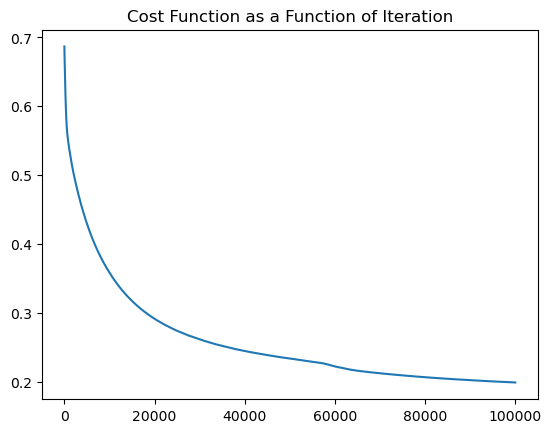

In [50]:
plt.plot(J_history)
plt.title('Cost Function as a Function of Iteration')
plt.show()

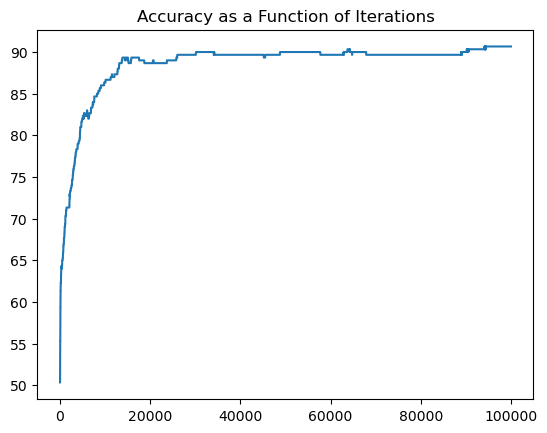

In [51]:
plt.plot(acc_history)
plt.title('Accuracy as a Function of Iterations')
plt.show()

In [52]:
# Accuracy at the End
acc_history[-1]

90.66666666666666

### Prediction for New Data

In [54]:
# Point to Check
x_test1 = np.array([[3, 3, 0]])

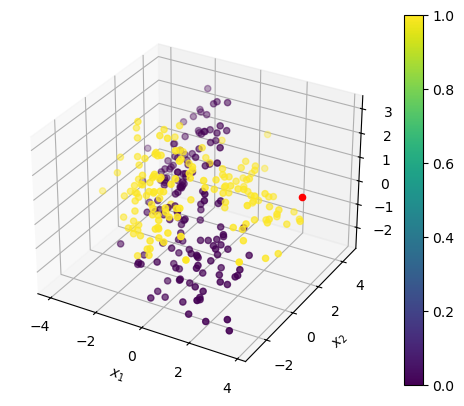

In [55]:
# New point marked with a red dot.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(X[:,0], X[:,1], X[:,2], c=Y.reshape(m,))
ax.scatter(x_test1[0][0], x_test1[0][1], x_test1[0][2], c='r')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
fig.colorbar(cax)
plt.show()

In [56]:
# Prediction close to 1 indicates a yellow dot, while close to 0 indicates a purple dot.
Z1, A1, Z2, A2, Y_hat = forward(x_test1.transpose(), W1, W2, b1, b2)
print(Y_hat)

[[0.9999619]]
